In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap
import os 

# Create a custom color map from white to black
white_black_cmap = LinearSegmentedColormap.from_list('white_black', ['white', 'black'], N=256)


# Example DataFrame
img_data_dir = './logs/ISR_Hessian_results_ViT-B_rescaled'
text_data_dir = './logs/ISR_Hessian_results_bert_rescaled'
cub_file = 'CUB_1runs_val.csv'
celeba_file = 'CelebA_1runs_val.csv'
multinli_file = 'MultiNLI_2runs_val.csv'

# df = pd.read_csv(os.path.join(img_data_dir, cub_file))
# df = pd.read_csv(os.path.join(img_data_dir, celeba_file))
df = pd.read_csv(os.path.join(text_data_dir, multinli_file))

# Creating a pivot table, averaging over 'penalty_anneal_iters'
pivot_df = df.pivot_table(values='worst_acc_mean', index='gradient_alpha', columns='hessian_beta', aggfunc='mean')


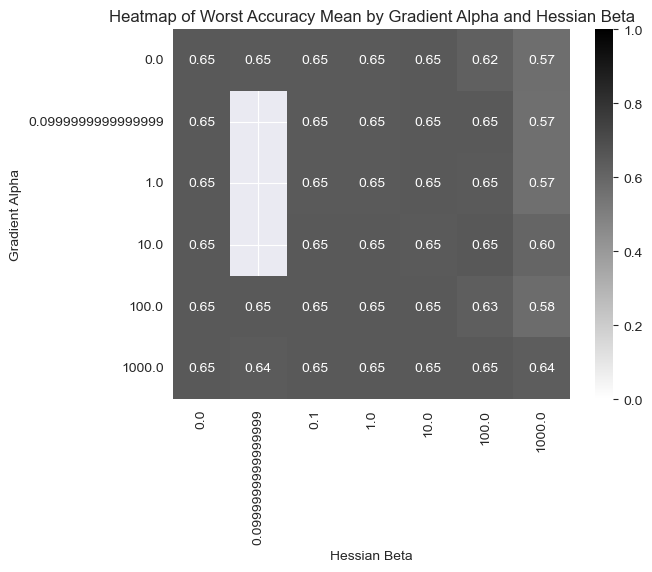

In [14]:
sns.heatmap(pivot_df, annot=True, cmap=white_black_cmap, fmt=".2f", vmin=0, vmax=1)
plt.title('Heatmap of Worst Accuracy Mean by Gradient Alpha and Hessian Beta')
plt.xlabel('Hessian Beta')
plt.ylabel('Gradient Alpha')
plt.show()


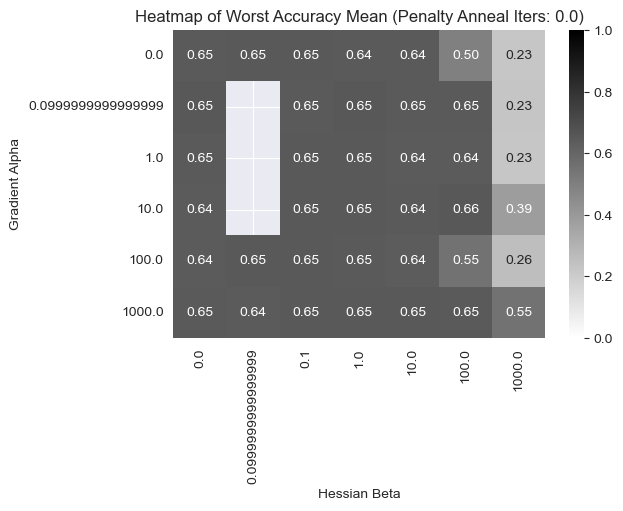

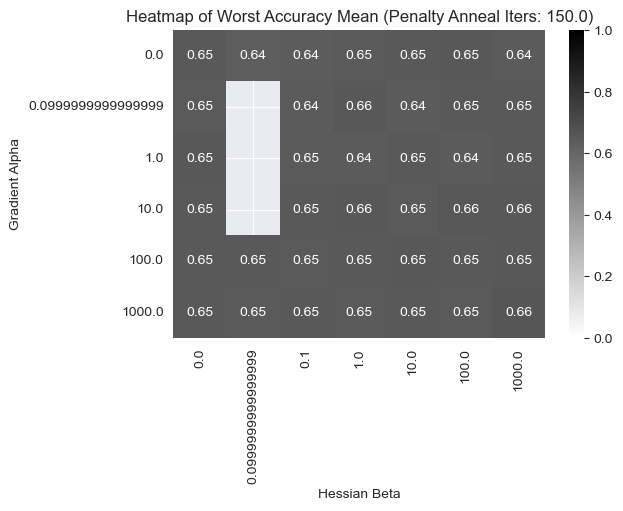

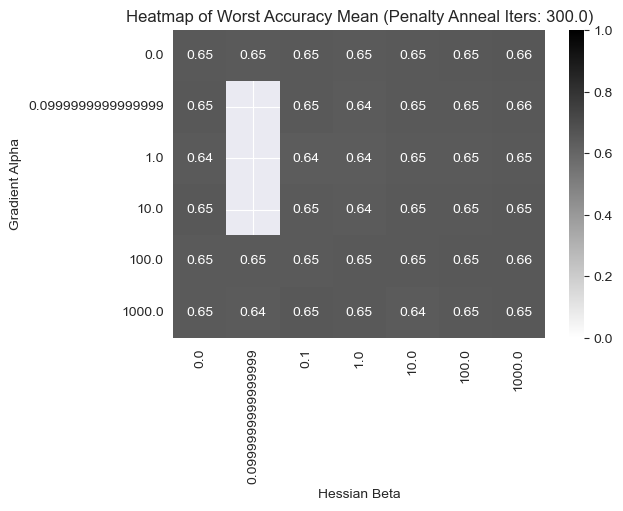

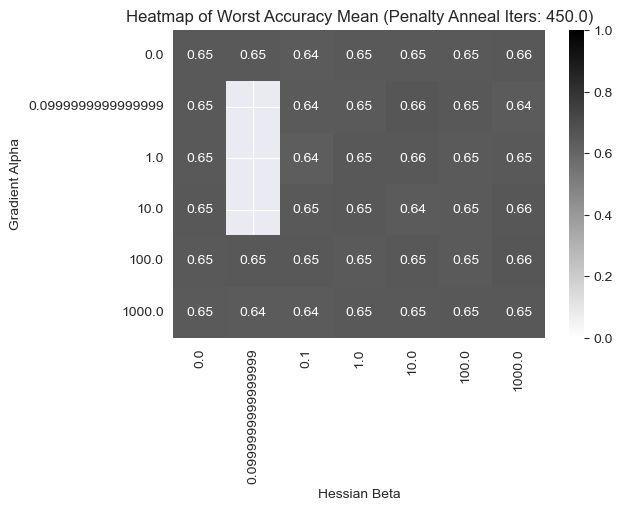

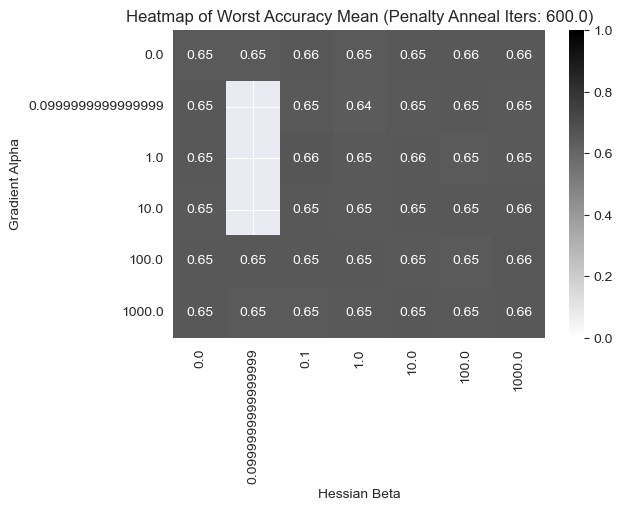

In [17]:
# We can create multiple heatmaps for each unique value of 'penalty_anneal_iters'
unique_iters = df['penalty_anneal_iters'].unique()

for iters in unique_iters:
    sub_df = df[df['penalty_anneal_iters'] == iters]
    pivot_df = sub_df.pivot_table(values='worst_acc_mean', index='gradient_alpha', columns='hessian_beta', aggfunc='mean')
    plt.figure(figsize=(6, 4))
    sns.heatmap(pivot_df, annot=True, cmap=white_black_cmap, fmt=".2f", vmin=0, vmax=1)
    plt.title(f'Heatmap of Worst Accuracy Mean (Penalty Anneal Iters: {iters})')
    plt.xlabel('Hessian Beta')
    plt.ylabel('Gradient Alpha')
    plt.show()
